In [18]:
import pandas as pd

In [19]:
weather = pd.read_csv('../Data/bna_weather.csv')

In [20]:
bus = pd.read_csv('../Data/headway_data.csv', index_col= False)

Remove an unnamed column that was on the csv file

In [21]:
bus = bus.loc[:, ~bus.columns.str.match('^Unnamed:')]

Convert the date column values to datetime format

In [22]:
bus['DATE'] = pd.to_datetime(bus['DATE'])

.info() to look at the data

In [23]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350328 entries, 0 to 350327
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   CALENDAR_ID                350328 non-null  int64         
 1   SERVICE_ABBR               350328 non-null  int64         
 2   ADHERENCE_ID               350328 non-null  int64         
 3   DATE                       350328 non-null  datetime64[ns]
 4   ROUTE_ABBR                 350328 non-null  int64         
 5   BLOCK_ABBR                 350328 non-null  int64         
 6   OPERATOR                   350328 non-null  int64         
 7   TRIP_ID                    350328 non-null  int64         
 8   OVERLOAD_ID                350328 non-null  int64         
 9   ROUTE_DIRECTION_NAME       350328 non-null  object        
 10  TIME_POINT_ABBR            350328 non-null  object        
 11  ROUTE_STOP_SEQUENCE        350317 non-null  float64 

Ideas: Identify a unique identifier that identifies a trip in a single day!

Michael's suggestion:

    The tripid column is reused across days. If you want a unique identifier for a trip, you'll need to combine the tripid and some kind of date identifier, like date or calendarid.

In [24]:
bus['trip_date'] = bus['TRIP_ID'].astype('str') + bus['CALENDAR_ID'].astype('str')

In [25]:
bus_no_overload = bus[bus['OVERLOAD_ID']==0]

In [26]:
bus['trip_date'].describe()

count              350328
unique              67370
top       353036120230926
freq                   21
Name: trip_date, dtype: object

In [27]:
bus[bus['TRIP_EDGE']==1]['trip_date'].describe()

count               67415
unique              67361
top       350216120230907
freq                    2
Name: trip_date, dtype: object

Total unique trip_id is 67370

of which only 67361 of them have trip_edge =1 (START)


_some entries with trip_id are repeated twice (for starting) and three times (for trip_id =2) at most_

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
bus_start_end = bus_no_overload.groupby(
    ['trip_date','TRIP_EDGE']).filter(
        lambda x: (
            1 in x['TRIP_EDGE'].values) or (
                2 in x['TRIP_EDGE'].values))



In [29]:
bus_start_end_grouped =  bus_start_end.groupby(['trip_date','TRIP_EDGE'])['ADHERENCE'].apply(list).reset_index()

In [30]:
bus_start_end_grouped

,trip_date,TRIP_EDGE,ADHERENCE
0,345104120230801,1,[-2.133333]
1,345104120230801,2,[6.283333]
2,345104120230802,1,[-2.45]
3,345104120230802,2,[8.016666]
4,345104120230803,1,[-0.766666]
...,...,...,...
134704,354106120230927,2,[-166.566666]
134705,354106120230928,1,[-2.566666]
134706,354106120230928,2,[-5.816666]
134707,354106120230929,1,[-20.616666]


In [31]:
# Loop over the 'list_column' and count the number of items in each list
for row in bus_start_end_grouped['ADHERENCE']:
    count = len(row)
    if count != 1:
        print('Not One')

#### There's only one item in all the list of the column


In [32]:
grouped_reset = bus_start_end.groupby(['trip_date','TRIP_EDGE'])['ADHERENCE'].mean().reset_index()

In [33]:
grouped_reset

,trip_date,TRIP_EDGE,ADHERENCE
0,345104120230801,1,-2.133333
1,345104120230801,2,6.283333
2,345104120230802,1,-2.450000
3,345104120230802,2,8.016666
4,345104120230803,1,-0.766666
...,...,...,...
134704,354106120230927,2,-166.566666
134705,354106120230928,1,-2.566666
134706,354106120230928,2,-5.816666
134707,354106120230929,1,-20.616666


Goal is to plot adherence for each trip with edge=2 vs edge =1 

Problem: They are not the same dimenstions

In [34]:
grouped_reset['TRIP_EDGE'].iloc[1::2]

1         2
3         2
5         2
7         2
9         2
         ..
134699    1
134701    1
134703    1
134705    1
134707    1
Name: TRIP_EDGE, Length: 67354, dtype: int64

In [35]:

# Calculate differences
grouped_reset['differences'] = grouped_reset['TRIP_EDGE'].diff()

# Set a threshold for detecting breaks
threshold = 1
grouped_reset['periodicity_break'] = abs(grouped_reset['differences']) != threshold
grouped_reset

,trip_date,TRIP_EDGE,ADHERENCE,differences,periodicity_break
0,345104120230801,1,-2.133333,NaN,True
1,345104120230801,2,6.283333,1.0,False
2,345104120230802,1,-2.450000,-1.0,False
3,345104120230802,2,8.016666,1.0,False
4,345104120230803,1,-0.766666,-1.0,False
...,...,...,...,...,...
134704,354106120230927,2,-166.566666,1.0,False
134705,354106120230928,1,-2.566666,-1.0,False
134706,354106120230928,2,-5.816666,1.0,False
134707,354106120230929,1,-20.616666,-1.0,False


In [36]:
grouped_reset = grouped_reset[(grouped_reset['periodicity_break']==False) | (grouped_reset['differences'].isna())]

In [37]:
grouped_reset.groupby('trip_date')['TRIP_EDGE']

In [38]:
grouped_reset['TRIP_EDGE'].value_counts()

TRIP_EDGE
1    67351
2    67351
Name: count, dtype: int64

Text(0, 0.5, 'Adherence for the end of the trip')

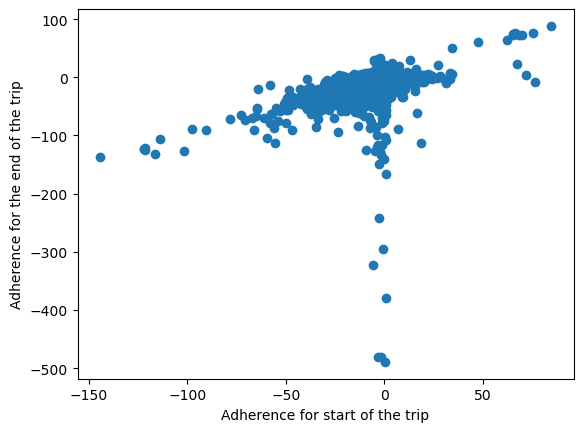

In [39]:
plt.plot(grouped_reset[grouped_reset['TRIP_EDGE']==1]['ADHERENCE']
         ,grouped_reset[grouped_reset['TRIP_EDGE']==2]['ADHERENCE'],'o')
plt.xlabel('Adherence for start of the trip')
plt.ylabel('Adherence for the end of the trip')

### some notes
- Actual Arrival time   32724
- Actual Departure time 32720
- Adherence             32720
- Scheduled Headway     32835
- Actual headway        31831
- Headway deviation     31773
- Dwell time            32720

Question : 5

5. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

Ideas:
    Headway : Measured with headway_deviation
    on-time preformance : Measured with adherence !

Drivers !!

In [40]:
bus['OPERATOR'].nunique()

341

In [41]:
bus.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS', 'trip_date'],
      dtype='object')

In [82]:
bus.groupby('OPERATOR')['trip_date'].nunique().sort_values()

OPERATOR
0         1
473       1
656       1
56        2
3077      2
       ... 
2352    548
379     553
2164    574
1761    738
1762    803
Name: trip_date, Length: 341, dtype: int64

In [68]:
grouped_by_operator = bus.groupby('OPERATOR')['trip_date'].nunique().reset_index()

In [88]:
result = grouped_by_operator[grouped_by_operator['trip_date']>500]

In [92]:
operators_of_interest = result['OPERATOR'].tolist()

In [96]:
bus_subset = bus[bus['OPERATOR'].isin (operators_of_interest)]

In [97]:
bus_subset

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,trip_date
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,2,6.500000,345104120230801
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,9,0.000000,345104120230801
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,19,0.000000,345104120230801
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,NaN,0,35,0.000000,345104120230801
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,0,0,1,0,0.0,0,36,12.866666,345105120230801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348268,120230930,2,100404311,2023-09-30,52,5201,2352,352036,0,FROM DOWNTOWN,...,NaN,0,0,0,0,0.0,0,741,NaN,352036120230930
348269,120230930,2,100404312,2023-09-30,52,5201,2352,352036,0,FROM DOWNTOWN,...,NaN,0,0,0,0,0.0,0,748,NaN,352036120230930
348270,120230930,2,100404313,2023-09-30,52,5201,2352,352036,0,FROM DOWNTOWN,...,NaN,0,0,0,0,0.0,0,761,NaN,352036120230930
348271,120230930,2,100404314,2023-09-30,52,5201,2352,352036,0,FROM DOWNTOWN,...,NaN,0,0,0,0,0.0,0,786,NaN,352036120230930


/home/prahlad/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


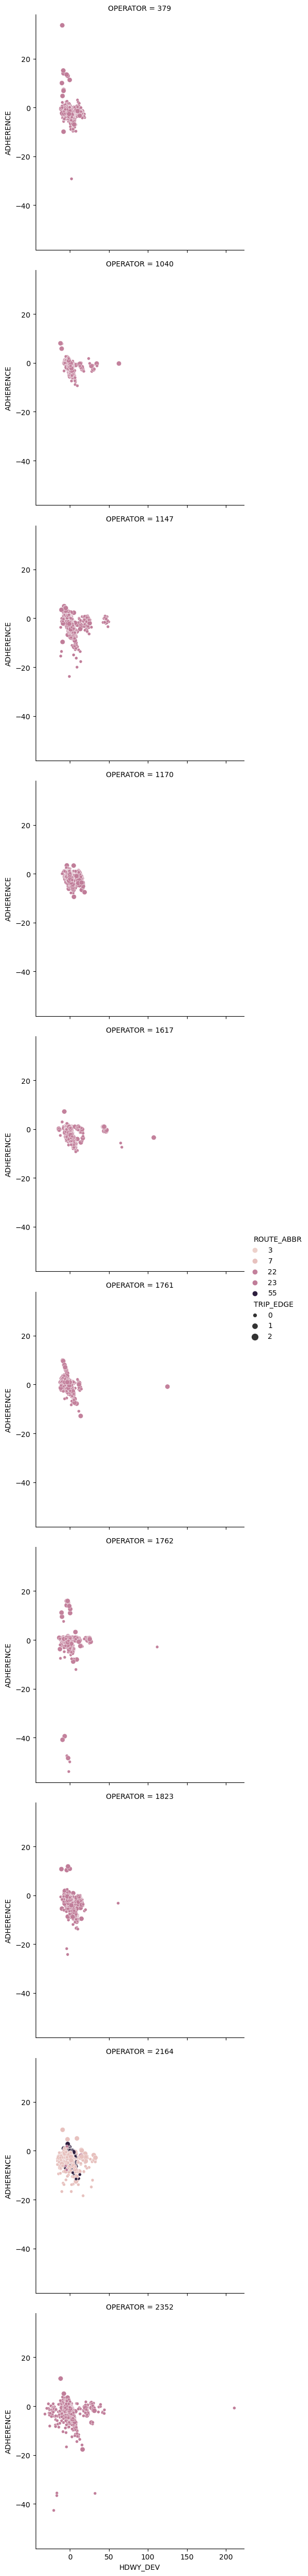

In [120]:
g = sns.relplot(data = bus_subset[bus_subset['SERVICE_ABBR']==1], x = 'HDWY_DEV', y = 'ADHERENCE', hue = 'ROUTE_ABBR', row = 'OPERATOR', size = 'TRIP_EDGE')
# g.set(ylim=(-50, 50))

In [ ]:
import plotly.express as px
g = sns.relplot(data = bus_subset[bus_subset['SERVICE_ABBR']==1], x = 'HDWY_DEV', y = 'ADHERENCE', hue = 'ROUTE_ABBR', row = 'OPERATOR', size = 'TRIP_EDGE')

In [98]:
# Create a pivot table with multiple index and multiple columns
bus_pivot_table = pd.pivot_table(bus_subset, values=['HDWY_DEV', 'ADHERENCE'], index=['ROUTE_ABBR', 'SERVICE_ABBR', 'OPERATOR'], columns='TRIP_EDGE')
bus_pivot_table.head(5)

ADHERENCE                      HDWY_DEV  \
TRIP_EDGE                                0         1         2         0   
ROUTE_ABBR SERVICE_ABBR OPERATOR                                           
3          1            2164     -2.736111 -3.079166 -3.250000  1.456944   
           3            1823     -3.823129 -5.271428 -0.119728  3.534864   
                        2352     -1.167433 -2.133760 -4.061681 -1.106562   
7          1            2164     -4.527189 -2.874023 -4.156809  0.558496   
           2            2164     -5.600000 -3.838746 -4.388095  0.865669   

                                            
TRIP_EDGE                                1  
ROUTE_ABBR SERVICE_ABBR OPERATOR            
3          1            2164      1.504166  
           3            1823      3.810544  
                        2352     -0.391026  
7          1            2164      0.693099  
           2            2164     -0.579487

In [99]:
bus_pivot_table.index

MultiIndex([( 3, 1, 2164),
            ( 3, 3, 1823),
            ( 3, 3, 2352),
            ( 7, 1, 2164),
            ( 7, 2, 2164),
            ( 7, 3, 1617),
            ( 7, 3, 2164),
            (22, 1, 1040),
            (22, 1, 1617),
            (22, 1, 1761),
            (22, 1, 1762),
            (22, 3, 1617),
            (23, 1,  379),
            (23, 1, 1147),
            (23, 1, 1170),
            (23, 1, 1823),
            (23, 1, 2164),
            (23, 1, 2352),
            (23, 2,  379),
            (23, 3, 1147),
            (52, 2, 2352),
            (55, 1, 2164),
            (55, 3, 2164)],
           names=['ROUTE_ABBR', 'SERVICE_ABBR', 'OPERATOR'])

In [104]:
bus_pivot_table.loc[(22,1)]

ADHERENCE                      HDWY_DEV          
TRIP_EDGE         0         1         2         0         1
OPERATOR                                                   
1040      -1.381828 -1.178317  2.139794  0.609271  0.221512
1617      -1.469109 -1.009784  1.865672  0.014338  1.504311
1761       0.027458 -0.029388  3.851255 -2.381535 -0.896079
1762      -0.519337  0.128106  3.885961 -2.561478 -1.364910

_How to slice a multi-index pivot table?_

- I want to plot Adherence on a weekday in a route for all the operators

- Problem with this is there are too many operators 

- I also want to choose operators that have more trips to be statistically significant

In [106]:
operator_df = bus_subset.groupby(['OPERATOR','SERVICE_ABBR'])['ADHERENCE'].count().sort_index()#.plot(kind='line', rot = 90)
operator_df
#grouped_reset = bus_start_end.groupby(['trip_date','TRIP_EDGE'])['ADHERENCE'].mean().reset_index()

OPERATOR  SERVICE_ABBR
379       1               1775
          2                484
1040      1               1770
1147      1               2640
          3                 46
1170      1               2123
1617      1               1534
          3                272
1761      1               2126
1762      1               2332
1823      1               1796
          3                294
2164      1               1154
          2                353
          3                402
2352      1               1685
          2                338
          3                582
Name: ADHERENCE, dtype: int64

/home/prahlad/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


MergeError: Not allowed to merge between different levels. (2 levels on the left, 1 on the right)

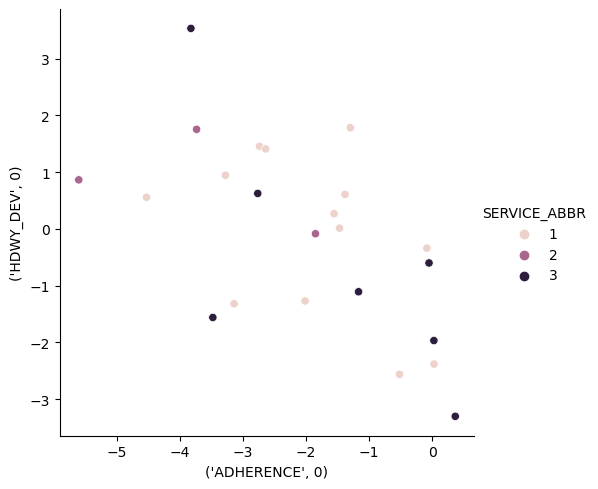

In [103]:
sns.relplot(data = bus_pivot_table, x = ('ADHERENCE',0), y = ('HDWY_DEV',0), kind = 'scatter', hue = 'SERVICE_ABBR')

In [122]:
bus['ADHERENCE_ID'].nunique()

350328

In [127]:
bus.shape

(350328, 31)

In [128]:
bus['trip_date'].nunique()

67370

In [129]:
complete_trips = pd.read_csv('../Data/data_complete_trips.csv')